In [149]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from math import sin, cos, sqrt, atan2, radians
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
import statsmodels.formula.api as smf

In [150]:
#opening our data
mm_data = pd.read_csv('allseasons.csv').query("season<2020").reset_index(drop=True)

In [151]:
#data = data.drop(columns=['WLoc','team1_position','team2_position','team1_region','team2_region','slot','host','team1_teamname','team2_teamname','game_id'])

## log odds

In [152]:
##expected win percentage vs avg team
mm_data['exp_win1'] = (mm_data['team1_adjoe']**11.5)/ ((mm_data['team1_adjde']**11.5)+(mm_data['team1_adjoe']**11.5))
mm_data['exp_win2'] = (mm_data['team2_adjoe']**11.5)/ ((mm_data['team2_adjde']**11.5)+(mm_data['team2_adjoe']**11.5))

In [153]:
mm_data['team1_log5'] = (mm_data['exp_win1'] - (mm_data['exp_win1']*mm_data['exp_win2']))/ (mm_data['exp_win1']+mm_data['exp_win2']-(2*mm_data['exp_win1']*mm_data['exp_win2']))

## diff dist

In [154]:
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [155]:
mm_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
mm_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [156]:
mm_data['diff_dist'] = mm_data['dist1'] - mm_data['dist2']

## Seed dif

In [157]:
mm_data['seed_diff'] = mm_data['team1_seed'] - mm_data['team2_seed']


### SRS diff

In [158]:
mm_data['srs_diff'] = mm_data['team1_SRS'] - mm_data['team2_SRS']

### Net rating

In [159]:
mm_data['net_rating_diff'] = (mm_data['team1_adjoe'] - mm_data['team1_adjde']) - (mm_data['team2_adjoe'] - mm_data['team2_adjde'])

## tempo

In [160]:
mm_data['diff_tempo'] = mm_data['team1_adjtempo'] - mm_data['team2_adjtempo']

## offensive eff


In [161]:
mm_data['diff_adjoe'] = mm_data['team1_adjoe'] - mm_data['team2_adjoe']

## win temp

In [162]:
mm_data['win_tempo_diff'] = (((mm_data['team1_adjoe'] - 100) -(100 - mm_data['team2_adjde'])+100)/100*((mm_data['team1_adjtempo'] + mm_data['team2_adjtempo'])/2)) - (((mm_data['team2_adjoe'] - 100) - (100 - mm_data['team1_adjde'])+100)/100*((mm_data['team1_adjtempo']+mm_data['team2_adjtempo'])/2))

### True Rebounding %

In [163]:
mm_data['TRB_diff'] = mm_data['team1_TRB%'] - mm_data['team2_TRB%']

### split data

In [164]:
mm_data.dropna(subset=['team1_log5'], inplace=True)

In [165]:
mm_data['team1_win'] = (mm_data['team1_score']>mm_data['team2_score']).astype(int)

In [166]:
training_columns = ['game_id','team1_win','team1_adjoe','team2_adjoe','team1_adjtempo','team2_adjtempo',
                                    'team2_adjde','team1_adjde','team1_fg2pct',
                    'team1_fg3pct','team1_ftpct','team2_fg2pct','team2_fg3pct','team2_ftpct','team1_TS%','team2_TS%',
                   'team1_blockpct','team2_blockpct','win_tempo_diff',
                   'team1_log5','diff_dist','seed_diff','net_rating_diff','srs_diff','TRB_diff']
mm_data_1 = mm_data.sample(frac=.5, random_state=15)[training_columns]
mm_data_2 = mm_data[~mm_data.index.isin(mm_data_1.index)][training_columns].reset_index(drop=True)
mm_data_1 = mm_data_1.reset_index(drop=True)

In [167]:
mm_data_2

,game_id,team1_win,team1_adjoe,team2_adjoe,team1_adjtempo,team2_adjtempo,team2_adjde,team1_adjde,team1_fg2pct,team1_fg3pct,...,team2_TS%,team1_blockpct,team2_blockpct,win_tempo_diff,team1_log5,diff_dist,seed_diff,net_rating_diff,srs_diff,TRB_diff
0,2019-1125-1396,1,114.952,108.9910,71.1915,68.8256,99.5630,101.8860,59.497207,37.112172,...,53.4,9.127302,6.315789,2.546911,0.585922,-307.876634,0,3.6380,0.95,4.0
1,2019-1295-1300,1,106.675,96.7551,64.8533,65.2686,108.6610,109.8730,52.445961,36.842105,...,54.5,6.643658,6.912029,5.665442,0.730051,663.316546,0,8.7079,7.52,-6.1
2,2019-1278-1257,1,110.803,113.5030,67.5056,67.1950,92.4983,96.3335,48.391813,32.129964,...,55.3,10.256410,8.048780,-4.401477,0.322116,-391.001293,3,-6.5352,-4.76,-1.2
3,2019-1261-1463,1,118.620,110.5520,69.9424,70.8110,102.2790,97.6208,53.430995,32.300885,...,58.4,12.020906,10.933082,8.956280,0.793493,-538.588141,-11,12.7262,10.98,0.1
4,2019-1120-1308,1,119.283,112.7330,67.5646,65.6538,99.1319,97.1706,51.383399,38.100102,...,56.2,16.099071,7.523810,5.669309,0.706674,1463.624314,-7,8.5113,10.79,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,2018-1181-1393,1,118.700,103.0000,70.0000,63.4000,98.3000,97.3000,55.648218,37.793103,...,51.8,13.189270,17.933723,11.138900,0.851839,-56.740049,-9,16.7000,11.54,2.9
585,2018-1437-1403,1,122.800,109.2000,68.3000,66.6000,94.2000,99.9000,59.713518,39.794872,...,55.5,10.219531,12.923923,5.328550,0.662444,-2412.607153,-2,7.9000,7.26,-0.2
586,2018-1260-1243,1,108.700,108.3000,65.3000,65.5000,101.6000,93.9000,56.534091,40.034072,...,56.0,6.773619,9.243697,5.297400,0.720863,-284.535852,2,8.1000,-2.48,3.9
587,2018-1276-1199,1,111.200,110.8000,64.4000,71.6000,101.4000,96.5000,54.339964,36.309524,...,56.2,8.228840,13.333333,3.604000,0.648177,-75.859795,-6,5.3000,3.25,-1.5


In [168]:
mm_data_2['team1_win'] = 0
mm_data_2['diff_dist'] = mm_data_2['diff_dist']*-1
mm_data_2['team1_log5'] = 1-mm_data_2['team1_log5']
mm_data_2['game_id'] = (mm_data_2['game_id'].str.split('-', expand=True)[0] 
                           + '-' + mm_data_2['game_id'].str.split('-', expand=True)[2] 
                           + '-' + mm_data_2['game_id'].str.split('-', expand=True)[1]
                           ) 
mm_data_2['seed_diff'] = mm_data_2['seed_diff']*-1
mm_data_2.columns =['game_id','team1_win','team1_adjoe','team2_adjoe','team1_adjtempo','team2_adjtempo',
                                    'team2_adjde','team1_adjde','team1_fg2pct',
                    'team1_fg3pct','team1_ftpct','team2_fg2pct','team2_fg3pct','team2_ftpct','team1_TS%','team2_TS%',
                   'team1_blockpct','team2_blockpct','win_tempo_diff',
                   'team1_log5','diff_dist','seed_diff','net_rating_diff','srs_diff','TRB_diff']

In [169]:
mm_train = pd.concat([mm_data_2, mm_data_1]).reset_index(drop=True)

In [170]:
#mm_train['team1_SRS'] = mm_train['team1_SRS'].fillna(0)
#mm_train['team2_SRS'] = mm_train['team2_SRS'].fillna(0)
mm_train['srs_diff'] = mm_train['srs_diff'].fillna(0)
mm_train['team1_TS%'] = mm_train['team1_TS%'].fillna(0)
mm_train['team2_TS%'] = mm_train['team2_TS%'].fillna(0)
mm_train['TRB_diff'] = mm_train['TRB_diff'].fillna(0)

In [147]:
#mm_train['team1_win']=mm_train['team1_win'].replace(1,2)
mm_train['team1_win']=mm_train['team1_win'].replace(0,2)

In [171]:
data = mm_train
data = data.drop(columns=['game_id'])

In [172]:
data.groupby('team1_win')['team1_log5'].mean()

team1_win
0    0.360954
1    0.605706
Name: team1_log5, dtype: float64

In [173]:
data

,team1_win,team1_adjoe,team2_adjoe,team1_adjtempo,team2_adjtempo,team2_adjde,team1_adjde,team1_fg2pct,team1_fg3pct,team1_ftpct,...,team2_TS%,team1_blockpct,team2_blockpct,win_tempo_diff,team1_log5,diff_dist,seed_diff,net_rating_diff,srs_diff,TRB_diff
0,0,114.9520,108.9910,71.1915,68.8256,99.5630,101.8860,59.497207,37.112172,73.556797,...,53.4,9.127302,6.315789,2.546911,0.414078,307.876634,0,3.6380,0.95,4.0
1,0,106.6750,96.7551,64.8533,65.2686,108.6610,109.8730,52.445961,36.842105,76.470588,...,54.5,6.643658,6.912029,5.665442,0.269949,-663.316546,0,8.7079,7.52,-6.1
2,0,110.8030,113.5030,67.5056,67.1950,92.4983,96.3335,48.391813,32.129964,67.945545,...,55.3,10.256410,8.048780,-4.401477,0.677884,391.001293,-3,-6.5352,-4.76,-1.2
3,0,118.6200,110.5520,69.9424,70.8110,102.2790,97.6208,53.430995,32.300885,75.403226,...,58.4,12.020906,10.933082,8.956280,0.206507,538.588141,11,12.7262,10.98,0.1
4,0,119.2830,112.7330,67.5646,65.6538,99.1319,97.1706,51.383399,38.100102,71.266234,...,56.2,16.099071,7.523810,5.669309,0.293326,-1463.624314,7,8.5113,10.79,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,1,114.0809,114.2741,66.2369,66.9406,89.9466,98.0954,51.023500,39.731500,74.638500,...,53.4,6.460100,11.738300,-5.554834,0.265653,774.656517,1,-8.3420,-4.28,-1.2
1175,1,117.9750,104.6730,66.3703,72.5707,101.9460,95.1305,53.414000,36.560900,75.071200,...,54.0,8.985300,9.026700,13.975728,0.897660,1347.865301,-11,20.1175,17.18,0.0
1176,1,110.0334,103.1107,64.4347,62.8191,88.9640,95.5252,49.856700,36.363600,66.156000,...,52.1,13.104700,8.753300,0.230011,0.482247,-243.369216,-7,0.3615,0.17,-4.4
1177,1,112.8260,125.2580,66.6081,69.8432,92.3982,86.0594,52.884615,36.767036,72.773109,...,62.0,15.317073,13.574661,-4.157125,0.404975,-58.644552,2,-6.0932,-5.00,-3.9


### random forest classifier

In [205]:
## reset data to maybe change variables
data = mm_train
data = data.drop(columns=['game_id'])

In [175]:
#use this line to change the variables of the random forest model

data = data[['team1_win','team1_adjoe', 'team2_adjoe', 'team2_adjde', 'team1_adjde',
       'win_tempo_diff', 'team1_log5', 'diff_dist', 'seed_diff',
       'net_rating_diff', 'srs_diff']]


In [206]:
#sets team1win as first columns, which makes it easier to set into array
data = data[ ['team1_win'] + [ col for col in data.columns if col != 'team1_win' ] ]

In [207]:
data

,team1_win,team1_adjoe,team2_adjoe,team1_adjtempo,team2_adjtempo,team2_adjde,team1_adjde,team1_fg2pct,team1_fg3pct,team1_ftpct,...,team2_TS%,team1_blockpct,team2_blockpct,win_tempo_diff,team1_log5,diff_dist,seed_diff,net_rating_diff,srs_diff,TRB_diff
0,0,114.9520,108.9910,71.1915,68.8256,99.5630,101.8860,59.497207,37.112172,73.556797,...,53.4,9.127302,6.315789,2.546911,0.414078,307.876634,0,3.6380,0.95,4.0
1,0,106.6750,96.7551,64.8533,65.2686,108.6610,109.8730,52.445961,36.842105,76.470588,...,54.5,6.643658,6.912029,5.665442,0.269949,-663.316546,0,8.7079,7.52,-6.1
2,0,110.8030,113.5030,67.5056,67.1950,92.4983,96.3335,48.391813,32.129964,67.945545,...,55.3,10.256410,8.048780,-4.401477,0.677884,391.001293,-3,-6.5352,-4.76,-1.2
3,0,118.6200,110.5520,69.9424,70.8110,102.2790,97.6208,53.430995,32.300885,75.403226,...,58.4,12.020906,10.933082,8.956280,0.206507,538.588141,11,12.7262,10.98,0.1
4,0,119.2830,112.7330,67.5646,65.6538,99.1319,97.1706,51.383399,38.100102,71.266234,...,56.2,16.099071,7.523810,5.669309,0.293326,-1463.624314,7,8.5113,10.79,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,1,114.0809,114.2741,66.2369,66.9406,89.9466,98.0954,51.023500,39.731500,74.638500,...,53.4,6.460100,11.738300,-5.554834,0.265653,774.656517,1,-8.3420,-4.28,-1.2
1175,1,117.9750,104.6730,66.3703,72.5707,101.9460,95.1305,53.414000,36.560900,75.071200,...,54.0,8.985300,9.026700,13.975728,0.897660,1347.865301,-11,20.1175,17.18,0.0
1176,1,110.0334,103.1107,64.4347,62.8191,88.9640,95.5252,49.856700,36.363600,66.156000,...,52.1,13.104700,8.753300,0.230011,0.482247,-243.369216,-7,0.3615,0.17,-4.4
1177,1,112.8260,125.2580,66.6081,69.8432,92.3982,86.0594,52.884615,36.767036,72.773109,...,62.0,15.317073,13.574661,-4.157125,0.404975,-58.644552,2,-6.0932,-5.00,-3.9


In [208]:
#Choose which variable you would like to remove for this data set
#data = data.drop(columns=['srs_diff'])
#data = data.drop(columns=['net_rating_diff'])
#data = data.drop(columns=['diff_dist'])
#data = data.drop(columns=['team1_log5'])

In [357]:
X = data
y = data['team1_win']
X = X.drop(columns=['team1_win'])

In [358]:
# to gather a list of important variables once random forest model is built
data_list = list(X.columns)
#data_list = data_list.remove('team1_win')

In [359]:
#turns data into array, this can be skipped
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

In [360]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [361]:
X_train

array([[ 1.162551e+02,  1.096136e+02,  7.541800e+01, ...,  5.021500e+00,
         4.270000e+00,  1.200000e+00],
       [ 1.123967e+02,  1.131231e+02,  6.468270e+01, ..., -4.500000e-02,
         1.620000e+00, -8.000000e-01],
       [ 1.075194e+02,  1.160830e+02,  6.786620e+01, ..., -1.452100e+00,
        -1.590000e+00, -3.200000e+00],
       ...,
       [ 1.105509e+02,  1.063486e+02,  6.602290e+01, ...,  1.000990e+01,
         1.010000e+01,  3.400000e+00],
       [ 1.202030e+02,  1.083640e+02,  7.117700e+01, ...,  1.442840e+01,
         1.150000e+01,  6.500000e+00],
       [ 1.161109e+02,  1.094072e+02,  6.555950e+01, ...,  1.326080e+01,
         1.237000e+01,  4.300000e+00]])

In [362]:
from sklearn import preprocessing

X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

In [363]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [364]:
X_test

array([[-1.16457061, -1.20565825, -1.17644892, ..., -0.24340285,
        -0.27669662, -0.07311924],
       [-0.0196968 ,  0.17789982,  0.24480964, ..., -1.03275455,
        -0.93214697, -0.00719167],
       [-0.54464495, -0.54838522, -0.63774343, ..., -0.13957456,
        -0.1668316 ,  0.18063034],
       ...,
       [-0.71410515, -0.84456512, -0.8987197 , ...,  0.63531024,
         0.51732113, -0.32405477],
       [ 0.74616193,  0.65852677,  0.52454122, ...,  0.9633568 ,
         1.23733925,  0.88103466],
       [ 0.96409064,  1.03115229,  1.20191508, ..., -0.45530569,
        -0.630443  , -1.42452136]])

In [365]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42,max_features = .08695652)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
predictions = rf.predict_proba(X_test)

In [366]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[113  40]
 [ 10 132]]
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       153
           1       0.77      0.93      0.84       142

    accuracy                           0.83       295
   macro avg       0.84      0.83      0.83       295
weighted avg       0.85      0.83      0.83       295

0.8305084745762712


In [367]:
predictions

array([[0.8 , 0.2 ],
       [0.62, 0.38],
       [0.32, 0.68],
       [0.52, 0.48],
       [0.66, 0.34],
       [0.18, 0.82],
       [0.45, 0.55],
       [0.71, 0.29],
       [0.39, 0.61],
       [0.37, 0.63],
       [0.38, 0.62],
       [0.29, 0.71],
       [0.43, 0.57],
       [0.55, 0.45],
       [0.26, 0.74],
       [0.51, 0.49],
       [0.51, 0.49],
       [0.8 , 0.2 ],
       [0.91, 0.09],
       [0.38, 0.62],
       [0.82, 0.18],
       [0.63, 0.37],
       [0.46, 0.54],
       [0.26, 0.74],
       [0.19, 0.81],
       [0.27, 0.73],
       [0.32, 0.68],
       [0.32, 0.68],
       [0.46, 0.54],
       [0.4 , 0.6 ],
       [0.61, 0.39],
       [0.57, 0.43],
       [0.73, 0.27],
       [0.81, 0.19],
       [0.62, 0.38],
       [0.64, 0.36],
       [0.3 , 0.7 ],
       [0.14, 0.86],
       [0.24, 0.76],
       [0.44, 0.56],
       [0.42, 0.58],
       [0.39, 0.61],
       [0.82, 0.18],
       [0.84, 0.16],
       [0.33, 0.67],
       [0.23, 0.77],
       [0.24, 0.76],
       [0.22,

In [368]:
accuracy_RF2 = cross_val_score(rf,X,y,scoring = 'accuracy')
log_loss_RF2 = cross_val_score(rf,X,y,scoring = 'neg_log_loss')

In [369]:
print("Accuracy: ", (accuracy_RF2.mean(), accuracy_RF2.std() * 2))
print("Log Loss: ", (log_loss_RF2.mean(), log_loss_RF2.std() * 2))

Accuracy:  (0.8329065993508836, 0.039645700582260066)
Log Loss:  (-0.4383650090873453, 0.018758777593710533)


In [370]:
scores = cross_val_score(rf, X_train, y_train.ravel(),cv=5, scoring = 'f1')
print ("mean validation F1 for Random Forests:","%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

mean validation F1 for Random Forests: 0.82 (+/- 0.03)


In [371]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
data_importances = [(data, round(importance, 5)) for data, importance in zip(data_list, importances)]

# Sort the feature importances by most important first
data_importances = sorted(data_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in data_importances];

Variable: seed_diff            Importance: 0.13088
Variable: team1_log5           Importance: 0.10009
Variable: win_tempo_diff       Importance: 0.05823
Variable: net_rating_diff      Importance: 0.05333
Variable: srs_diff             Importance: 0.05103
Variable: diff_dist            Importance: 0.04059
Variable: team2_blockpct       Importance: 0.03582
Variable: TRB_diff             Importance: 0.03561
Variable: team1_adjtempo       Importance: 0.03469
Variable: team2_adjde          Importance: 0.03439
Variable: team1_adjde          Importance: 0.03436
Variable: team1_blockpct       Importance: 0.03429
Variable: team1_fg2pct         Importance: 0.03419
Variable: team1_adjoe          Importance: 0.03395
Variable: team2_adjoe          Importance: 0.03395
Variable: team1_fg3pct         Importance: 0.03296
Variable: team2_fg3pct         Importance: 0.03224
Variable: team2_adjtempo       Importance: 0.03211
Variable: team2_fg2pct         Importance: 0.03187
Variable: team1_ftpct          

## Feature Selection

In [336]:
from sklearn.feature_selection import SelectFromModel

In [337]:
X.shape

(1179, 23)

In [338]:
rf.feature_importances_

array([0.03470334, 0.03207454, 0.03139983, 0.0316608 , 0.04210723,
       0.0318063 , 0.03346463, 0.03164118, 0.02940384, 0.03158887,
       0.03258689, 0.03029765, 0.0290692 , 0.03091527, 0.03356261,
       0.03160398, 0.05088294, 0.12221726, 0.04504881, 0.12113344,
       0.05705415, 0.05277159, 0.03300564])

In [339]:
model = SelectFromModel(rf, prefit=True)

In [340]:
X_new = model.transform(X)

In [341]:
X_new

array([[ 2.54691105e+00,  4.14078028e-01,  3.07876634e+02,
         0.00000000e+00,  3.63800000e+00,  9.50000000e-01],
       [ 5.66544247e+00,  2.69948649e-01, -6.63316546e+02,
         0.00000000e+00,  8.70790000e+00,  7.52000000e+00],
       [-4.40147681e+00,  6.77884064e-01,  3.91001293e+02,
        -3.00000000e+00, -6.53520000e+00, -4.76000000e+00],
       ...,
       [ 2.30011244e-01,  4.82247137e-01, -2.43369216e+02,
        -7.00000000e+00,  3.61500000e-01,  1.70000000e-01],
       [-4.15712531e+00,  4.04974737e-01, -5.86445517e+01,
         2.00000000e+00, -6.09320000e+00, -5.00000000e+00],
       [-4.13618810e+00,  3.04657409e-01, -1.60357819e+02,
         5.00000000e+00, -6.28740000e+00, -9.35000000e+00]])

In [342]:
X_new.shape

(1179, 6)

In [343]:
feature_names = np.array(data_list)

In [344]:
feature_names[model.get_support()]

array(['win_tempo_diff', 'team1_log5', 'diff_dist', 'seed_diff',
       'net_rating_diff', 'srs_diff'], dtype='<U15')

## Feature Selection (RFE)

In [345]:
from sklearn.feature_selection import RFE

In [346]:
rfe = RFE(estimator=rf, n_features_to_select=10, step=1)
rfe.fit(X, y)

RFE(estimator=RandomForestClassifier(max_features=0.08695652, random_state=42),
    n_features_to_select=10)

In [347]:
X_new_RFE = rfe.transform(X)

In [348]:
X_new_RFE

array([[114.952 , 108.991 ,  99.563 , ...,   0.    ,   3.638 ,   0.95  ],
       [106.675 ,  96.7551, 108.661 , ...,   0.    ,   8.7079,   7.52  ],
       [110.803 , 113.503 ,  92.4983, ...,  -3.    ,  -6.5352,  -4.76  ],
       ...,
       [110.0334, 103.1107,  88.964 , ...,  -7.    ,   0.3615,   0.17  ],
       [112.826 , 125.258 ,  92.3982, ...,   2.    ,  -6.0932,  -5.    ],
       [114.0138, 110.2039,  90.5274, ...,   5.    ,  -6.2874,  -9.35  ]])

In [349]:
feature_names = np.array(data_list)

In [350]:
feature_names[rfe.get_support()]

array(['team1_adjoe', 'team2_adjoe', 'team2_adjde', 'team1_adjde',
       'win_tempo_diff', 'team1_log5', 'diff_dist', 'seed_diff',
       'net_rating_diff', 'srs_diff'], dtype='<U15')

## Feature Selection (RFECV)

In [307]:
from sklearn.feature_selection import RFECV

In [308]:
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=StratifiedKFold(),
    scoring="neg_log_loss",
)
rfecv.fit(X, y)

<IPython.core.display.Javascript object>

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(max_features=0.08695652, n_estimators=50,
                                       random_state=42),
      scoring='neg_log_loss')

In [309]:
selector = rfecv.fit(X, y)

In [310]:
selector.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False])

In [311]:
selector.ranking_

array([ 6,  8, 19, 12,  7,  9, 16, 21, 11, 14, 13, 22, 17, 20, 15, 10,  2,
        1,  5,  3,  1,  4, 18])

In [312]:
feature_names

array(['team1_adjoe', 'team2_adjoe', 'team1_adjtempo', 'team2_adjtempo',
       'team2_adjde', 'team1_adjde', 'team1_fg2pct', 'team1_fg3pct',
       'team1_ftpct', 'team2_fg2pct', 'team2_fg3pct', 'team2_ftpct',
       'team1_TS%', 'team2_TS%', 'team1_blockpct', 'team2_blockpct',
       'win_tempo_diff', 'team1_log5', 'diff_dist', 'seed_diff',
       'net_rating_diff', 'srs_diff', 'TRB_diff'], dtype='<U15')

In [313]:
feature_names[selector.get_support()]

array(['team1_log5', 'net_rating_diff'], dtype='<U15')

In [314]:
sorted(sklearn.metrics.SCORERS.keys())

<IPython.core.display.Javascript object>

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NameError: name 'rfecv' is not defined

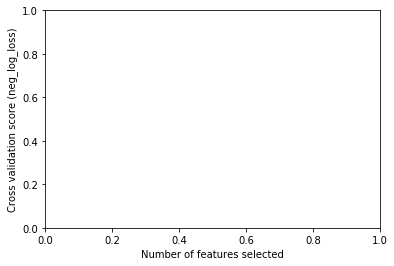

In [1]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_log_loss)")
plt.plot(
    range(1, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

## Create Example Submission


In [372]:
example_submission = pd.read_csv('MM_2022_Data.csv')

In [373]:
example_submission['dist1'] = example_submission.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
example_submission['dist2'] = example_submission.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)
example_submission['diff_dist'] = example_submission['dist1'] - example_submission['dist2']

In [374]:
example_submission['exp_win1'] = (example_submission['team1_adjoe']**11.5)/ ((example_submission['team1_adjde']**11.5)+(example_submission['team1_adjoe']**11.5))
example_submission['exp_win2'] = (example_submission['team2_adjoe']**11.5)/ ((example_submission['team2_adjde']**11.5)+(example_submission['team2_adjoe']**11.5))
example_submission['team1_log5'] = (example_submission['exp_win1'] - (example_submission['exp_win1']*example_submission['exp_win2']))/ (example_submission['exp_win1']+example_submission['exp_win2']-(2*example_submission['exp_win1']*example_submission['exp_win2']))

In [390]:
example_submission['TRB_diff'] = example_submission['team1_TRB%'] - example_submission['team2_TRB%']
example_submission['seed_diff'] = example_submission['team1_seed'] - example_submission['team2_seed']
example_submission['diff_tempo'] = example_submission['team1_adjtempo'] - example_submission['team2_adjtempo']
example_submission['diff_adjoe'] = example_submission['team1_adjoe'] - example_submission['team2_adjoe']
example_submission['srs_diff'] = example_submission['team1_SRS'] - example_submission['team2_SRS']
example_submission['net_rating_diff'] = (example_submission['team1_adjoe'] - example_submission['team1_adjde']) - (example_submission['team2_adjoe'] - example_submission['team2_adjde'])
example_submission['win_tempo_diff'] = (((example_submission['team1_adjoe'] - 100) -(100 - example_submission['team2_adjde'])+100)/100*((example_submission['team1_adjtempo'] + example_submission['team2_adjtempo'])/2)) - (((example_submission['team2_adjoe'] - 100) - (100 - example_submission['team1_adjde'])+100)/100*((example_submission['team1_adjtempo']+example_submission['team2_adjtempo'])/2))

In [401]:
test = example_submission[['team1_adjoe','team2_adjoe','team1_adjtempo','team2_adjtempo',
                                    'team2_adjde','team1_adjde','team1_fg2pct',
                    'team1_fg3pct','team1_ftpct','team2_fg2pct','team2_fg3pct','team2_ftpct','team1_TS%','team2_TS%',
                   'team1_blockpct','team2_blockpct','win_tempo_diff',
                   'team1_log5','diff_dist','seed_diff','net_rating_diff','srs_diff','TRB_diff']]

In [397]:
test = example_submission[['team1_adjoe', 'team2_adjoe', 'team2_adjde', 'team1_adjde',
       'win_tempo_diff', 'team1_log5', 'diff_dist', 'seed_diff',
       'net_rating_diff', 'srs_diff']]

In [402]:
test = test.iloc[:].values

In [403]:
#test = preprocessing.normalize(test)

In [404]:
test = sc.transform(test)

In [405]:
example_submission[['n','prob']] = rf.predict_proba(test)

In [406]:
example_submission[['winner']] = rf.predict(test)

In [408]:
example_submission[['game_id','prob','winner','team1_teamname','team2_teamname']]

,game_id,prob,winner,team1_teamname,team2_teamname
0,2022-1124-1246,0.45,0,Baylor,Kentucky
1,2022-1124-1345,0.63,1,Baylor,Purdue
2,2022-1124-1417,0.58,1,Baylor,UCLA
3,2022-1124-1388,0.58,1,Baylor,St Mary's CA
4,2022-1124-1400,0.58,1,Baylor,Texas
...,...,...,...,...,...
2273,2022-1436-1168,0.58,1,Vermont,CS Fullerton
2274,2022-1436-1209,0.58,1,Vermont,Georgia St
2275,2022-1286-1168,0.58,1,Montana St,CS Fullerton
2276,2022-1286-1209,0.58,1,Montana St,Georgia St


In [409]:
filter_prob = (example_submission.prob >= 0.5)
print("The teams who won with a greater than .50 probability of winning:", example_submission[filter_prob][['prob']].count())

The teams who won with a greater than .50 probability of winning: prob    1756
dtype: int64


In [385]:
example_submission[['game_id','prob','team1_teamname','team2_teamname']].to_csv("final_example_submission2.csv", index=False)